In [1]:
import urllib.request
import pandas
import xml.etree.ElementTree as ET

import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import timedelta

# 한글 폰트 설정
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 선형회귀 모델링


In [2]:
# 상 데이터만 먼저 사용
adf = pd.read_csv('./data/best.csv', index_col = 0)
display(adf.head())

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),2509.6,2833.0,0.0,특,4.3,0.0
5,20170103,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
9,20170104,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
13,20170105,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
17,20170106,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2


In [3]:
from sklearn.model_selection import train_test_split
check_columns = ['평균기온', '강수량']
X = adf[check_columns]
y = adf['평균가격']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [4]:
X_train.shape, y_train.shape

((1264, 2), (1264,))

In [5]:
X_test.shape, y_test.shape


((317, 2), (317,))

In [6]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

pred_test = lr.predict(X_test)

In [7]:
print(lr.coef_)

[-10.72476776   1.94758294]


In [8]:
# 성능 평가
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
#ㅋㅋㅋㅋ 그래,, 앞에서 데이터 확인해볼때 부터 알아봤다,,,
# 앞에서 예상한 대로 성능이 잘 안나온 것을 확인할 수 있음
# 1이랑 하나도 가깝지 않은 것을 볼 수 있음. 성능이 정말 안좋다.


0.008609597546200942
0.009087999164732796


In [9]:
# 그래도 한번 예측해봄, 평균기온과 강수량 데이터를 만들어서 넣어보았다.
test = {'평균기온':[25, 40, 0, -10],
        '강수량':[26, 0, 0, 70]}
testdf= pd.DataFrame(test)
display(testdf)

print(lr.predict(testdf))

#그래도 가격이 예측되긴 함, 결과를 보면 날이 좋으면 싸고, 춥고 비가 온 날은 가격이 비쌈

,평균기온,강수량
0,25,26
1,40,0
2,0,0
3,-10,70


[2418.46731734 2206.95864434 2635.9493549  2879.52783862]


### LSTM 모델링

In [10]:
# 굳이 csv로 저장 하지 않아도 되지만, 여러번 실험하기 위해 계속 데이터를 불러와서
# 자르고 나누고 하는 것 보다 정제된 데이터를 저장해야 겠다 생각하여 상 데이터를 저장해놓은
# best.csv 파일이다.
df = adf.copy()

# 데이터프레임의 인덱스를 날짜로 바꾸기 위해서 string으로 된 것을 pandas의 to_datetime을 이용해
# 바꿔 주고 set_index()를 통해 인덱스로 만들어준다.
df['날짜'] = df['날짜'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df = df.set_index('날짜')

display(df)

,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
날짜,,,,,,,
2017-01-01,대파(일반),2509.6,2833.0,0.0,특,4.3,0.0
2017-01-03,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
2017-01-04,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
2017-01-05,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
2017-01-06,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2
...,...,...,...,...,...,...,...
2021-05-23,대파(일반),2509.6,3364.0,1668.0,특,19.7,0.0
2021-05-24,대파(일반),3047.0,0.0,0.0,특,17.6,0.0
2021-05-25,대파(일반),3662.0,3047.0,1900.0,특,17.3,0.0


In [11]:
# 기본적인 pyplot 설정을 해놓는 것이다.
# 크기와, grid, -가 안나오는 것을 설정한 것이다.
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus'] = False



In [12]:
# 마지막으로 데이터프레임의 정보를 확인해 본다.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1581 entries, 2017-01-01 to 2021-05-27
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   품목명     1581 non-null   object 
 1   평균가격    1581 non-null   float64
 2   전일평균가격  1581 non-null   float64
 3   전년가격    1581 non-null   float64
 4   등급      1581 non-null   object 
 5   평균기온    1581 non-null   float64
 6   강수량     1581 non-null   float64
dtypes: float64(5), object(2)
memory usage: 98.8+ KB


<AxesSubplot:xlabel='날짜'>

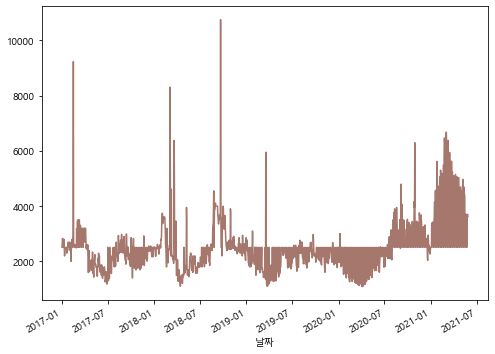

In [13]:
# 가격의 그래프를 확인해 본 것이다. 최근 가격이 많이 오른 것을 확인할 수 있다.
plt.rc('font', family='Malgun Gothic')
df['평균가격'].plot(color='#A6786D')

<AxesSubplot:xlabel='날짜'>

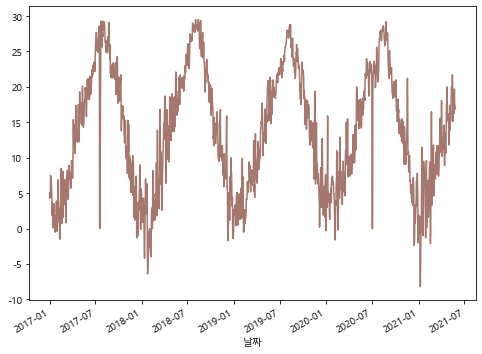

In [14]:
# 평균 기온을 확인한 것이다. 계절별로 온도 변화가 확실한 것을 볼 수 있다.
plt.rc('font', family='Malgun Gothic')
df['평균기온'].plot(color='#A6786D')


### 데이터 정규화

In [15]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

# 가격과, 기온, 강수량 모두 범위가 다르므로 각각 정규화를 해준다.
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()

scale_cols=['평균가격','평균기온','강수량']
dfs1 = scaler1.fit_transform(df[['평균가격']])
dfs2 = scaler2.fit_transform(df[['평균기온']])
dfs3 = scaler3.fit_transform(df[['강수량']])


df_scaled = pd.DataFrame()
df_scaled=pd.DataFrame(dfs1)
df_scaled.columns=['평균가격']
df_scaled[['평균기온']] = pd.DataFrame(dfs2)
df_scaled[['강수량']] = pd.DataFrame(dfs3)


In [16]:
# 각각 정규화를 해준 것을 하나로 합친다.
df_scaled.columns = scale_cols

display(df_scaled)

,평균가격,평균기온,강수량
0,0.147325,0.331565,0.000000
1,0.180793,0.352785,0.000000
2,0.177067,0.334218,0.000000
3,0.177067,0.416446,0.001639
4,0.177067,0.408488,0.000656
...,...,...,...
1576,0.147325,0.740053,0.000000
1577,0.202939,0.684350,0.000000
1578,0.266584,0.676393,0.000000
1579,0.260271,0.671088,0.002295


### 시계열 데이터의 데이터셋 분리

In [17]:
# 약 1500개의 데이터 중 테스트 사이즈를 200개로 하고 윈도우 사이즈를 20으로 한다.
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test= df_scaled[-TEST_SIZE:]

In [18]:
# 윈도우 사이즈에 맞춰 데이터를 다시 만들어주는 것이다.
def make_dataset(data, label, window_size = 20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list),np.array(label_list)

In [19]:
from sklearn.model_selection import train_test_split

feature_cols = ['평균기온', '강수량']
label_cols = ['평균가격']

# train데이터에서 찐으로 x와 y로 사용할 데이터를 나눈다.
train_feature = train[feature_cols]
train_label = train[label_cols]

# 윈도우 20사이즈로 바꿔준 것
train_feature, train_label = make_dataset(train_feature,train_label,20)

# train data를 train과 valid 데이터로 바꿔준다.
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
print(x_train.shape, x_valid.shape)

(1088, 20, 2) (273, 20, 2)


In [20]:
#train 데이터 확인
print(x_train)

[[[0.4137931  0.00491803]
  [0.38461538 0.08852459]
  [0.38196286 0.        ]
  ...
  [0.50928382 0.0295082 ]
  [0.42440318 0.        ]
  [0.4535809  0.        ]]

 [[0.84880637 0.        ]
  [0.82758621 0.16229508]
  [0.89124668 0.11639344]
  ...
  [0.933687   0.        ]
  [0.93633952 0.        ]
  [0.92572944 0.        ]]

 [[0.74535809 0.        ]
  [0.76127321 0.00196721]
  [0.76923077 0.        ]
  ...
  [0.64721485 0.        ]
  [0.70026525 0.        ]
  [0.70291777 0.        ]]

 ...

 [[0.93633952 0.        ]
  [0.9602122  0.        ]
  [0.9602122  0.        ]
  ...
  [0.9071618  0.00163934]
  [0.8938992  0.00098361]
  [0.91246684 0.        ]]

 [[0.84350133 0.        ]
  [0.81697613 0.        ]
  [0.78249337 0.        ]
  ...
  [0.64190981 0.        ]
  [0.70822281 0.00983607]
  [0.70822281 0.36721311]]

 [[0.95225464 0.        ]
  [0.92572944 0.        ]
  [0.91777188 0.        ]
  ...
  [0.82758621 0.03508197]
  [0.82493369 0.        ]
  [0.77984085 0.        ]]]


In [21]:
# 테스트 데이터도 트레인 데이터와 마찬가지로 x,y를 나눠주고 윈도우 크기 20으로 나눠준다.
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 2), (180, 1))

### 모형 학습

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
import tensorflow as tf

tf.random.set_seed(715)

In [23]:
#lstm 모델을 만들어준다. 여기서 모델을 한 층 더 쌓으면 과적합이 되어 한 밖에 쌓지 못했다.
lstmodel = Sequential()
lstmodel.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False))

lstmodel.add(Dense(1))

In [24]:
# 처음에 input size를 찾기 어려워 한번 출력해 본 것이다.
print(train_feature.shape[1])
print(train_feature.shape[2])

20
2


In [25]:
# loss를 여러 가지 사용했는데 이 loss가 가장 좋은 성능을 보였다.
lstmodel.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# 과적합을 방지하기 위해 early stopping을 사용하였다.

history = lstmodel.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=early_stop)

# 모델링을 보면 early_stopping에 의해 일찍 학습이 멈춘 것을 확인할 수 있다.

Epoch 1/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 10/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 11/

In [26]:
print(test_feature)
print(test_feature.shape)

[[[0.45888594 0.        ]
  [0.48541114 0.        ]
  [0.47480106 0.        ]
  ...
  [0.49071618 0.        ]
  [0.46419098 0.        ]
  [0.39257294 0.        ]]

 [[0.48541114 0.        ]
  [0.47480106 0.        ]
  [0.45888594 0.        ]
  ...
  [0.46419098 0.        ]
  [0.39257294 0.        ]
  [0.39787798 0.00196721]]

 [[0.47480106 0.        ]
  [0.45888594 0.        ]
  [0.50397878 0.        ]
  ...
  [0.39257294 0.        ]
  [0.39787798 0.00196721]
  [0.38461538 0.        ]]

 ...

 [[0.5862069  0.        ]
  [0.60742706 0.        ]
  [0.65782493 0.        ]
  ...
  [0.69230769 0.        ]
  [0.74005305 0.        ]
  [0.68435013 0.        ]]

 [[0.60742706 0.        ]
  [0.65782493 0.        ]
  [0.62068966 0.        ]
  ...
  [0.74005305 0.        ]
  [0.68435013 0.        ]
  [0.67639257 0.        ]]

 [[0.65782493 0.        ]
  [0.62068966 0.        ]
  [0.65251989 0.        ]
  ...
  [0.68435013 0.        ]
  [0.67639257 0.        ]
  [0.67108753 0.00229508]]]
(180, 20, 

In [27]:
pred= lstmodel.predict(test_feature)

pred.shape


(180, 1)

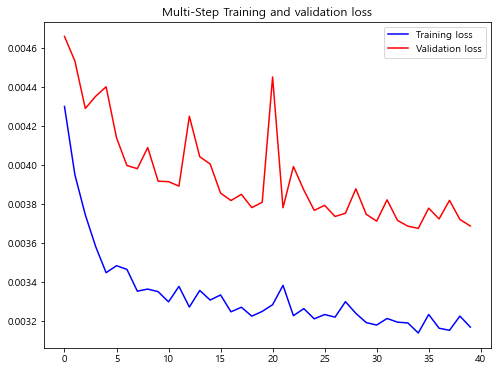

In [28]:
# loss 함수를 데이터로 그려보았다.
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

In [29]:
# 이 trainScore를 보면 모델을 컴파일 할 때 train_loss, val_loss와 같은 값이 나오는 것을
# 확인할 수 있다. 오차가 매우 작은 것을 볼 수 있다.
trainScore = lstmodel.evaluate(x_train, y_train, verbose=0)
print('Train Score: ',trainScore)

valScore = lstmodel.evaluate(x_valid, y_valid, verbose=0)
print('Validation Score: ',valScore)

Train Score:  0.0031447671353816986
Validation Score:  0.0036861856933683157


### 테스트 해 보기
최신 데이터를 다운로드 하여 input 데이터를 넣어 보고 예측해보기!

In [30]:
# 2021년 5월 6일부터, 2021년 6월 6일까지 데이터를 다운로드 했다.
test = pd.read_csv('./data/testdata2.csv', encoding='CP949')
display(test)

# 날씨 데이터의 NaN 값을 0으로 바꿔준다.
test=test.fillna(0)

,지점,지점명,일시,평균기온(°C),일강수량(mm)
0,268,진도군,2021-05-06,14.7,NaN
1,268,진도군,2021-05-07,16.6,NaN
2,268,진도군,2021-05-08,15.2,NaN
3,268,진도군,2021-05-09,16.4,NaN
4,268,진도군,2021-05-10,18.2,NaN
5,268,진도군,2021-05-11,19.7,NaN
6,268,진도군,2021-05-12,20.0,NaN
7,268,진도군,2021-05-13,19.0,NaN
8,268,진도군,2021-05-14,20.4,0.0
9,268,진도군,2021-05-15,21.7,20.5


In [31]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

test.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols=['평균기온(°C)','일강수량(mm)']
test_scaled=scaler.fit_transform(test[scale_cols])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = scale_cols

display(test_scaled)

,평균기온(°C),일강수량(mm)
0,0.000000,0.000000
1,0.240506,0.000000
2,0.063291,0.000000
3,0.215190,0.000000
4,0.443038,0.000000
5,0.632911,0.000000
6,0.670886,0.000000
7,0.544304,0.000000
8,0.721519,0.000000
9,0.886076,0.449561


In [32]:
feature_list = []

# 윈도우 사이즈에 맞게 스케일 해줌
for i in range(len(test_scaled) - 20):
    feature_list.append(np.array(test_scaled.iloc[i:i+20]))

test_input = np.array(feature_list)
# display(test_input)

In [33]:
test_pred = lstmodel.predict(test_input)
test_pred.shape

(12, 1)

In [34]:
# inverse_transform을 사용하여 정규화 했던 값을 원래 값으로 출력한다.
result = scaler1.inverse_transform(test_pred)
print(result)

[[4119.385 ]
 [3887.2754]
 [3766.9578]
 [3538.089 ]
 [3414.3396]
 [3212.2993]
 [3018.2485]
 [2828.316 ]
 [2644.7124]
 [2971.372 ]
 [3010.8667]
 [2267.6682]]


In [35]:
# 그 값들을 한눈에 알아보기 위해 한 데이터프레임으로 합친다.

check= pd.read_csv('./data/check.csv', index_col = 0)
display(check.head())

,날짜,품목명,평균가격,전일평균가격,전년가격,등급
1,20210526,대파(일반),3601,3662,1868,특
2,20210526,대파(일반),2152,2153,1623,상
3,20210526,대파(일반),1572,1676,1496,중
4,20210526,대파(일반),1180,1392,1208,하
1,20210527,대파(일반),3699,3601,1952,특


In [36]:
print('## groupby (등급) ##')
cgrouped = check.groupby('등급')

#그룹 확인
result_g = cgrouped.get_group(name='특')
result_g['결과'] = result
display(result_g[['날짜','평균가격','결과']])

## groupby (등급) ##


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,날짜,평균가격,결과
1,20210526,3601,4119.384766
1,20210527,3699,3887.275391
1,20210528,3755,3766.957764
1,20210529,2317,3538.089111
1,20210530,0,3414.339600
1,20210531,2202,3212.299316
1,20210601,2892,3018.248535
1,20210602,2837,2828.315918
1,20210603,2355,2644.712402
1,20210604,2268,2971.372070
